In [1]:
from matplotlib.axis import XAxis
from matplotlib.scale import LogScale
from scipy.optimize import minimize
from sklearn.naive_bayes import MultinomialNB

from util import *

In [2]:
plt.style.use("seaborn-v0_8")

1. Способы учитывания заголовка и тела сообщения при векторизации:
    * учитывать совместно, как будто нет никакого выделенного заголовка - один сплошной текст;
    * учитывать раздельно, выделив слова из заголовка в отдельное измерение.

2. Способы векторизации текста:
    * one-hot encoding;
    * вектор частот слов в тексте;
    * TF-IDF.

Считаем данные и представим их в виде объектов:

In [3]:
data = read_all_messages()
msg_types = extract_message_types(data)

3. Представим данные в табличном виде;
4. Построим наивный Байесовский классификатор;
5. Построим ROC-кривую, посчитаем AUC и найдем лучшую векторизацию относительно AUC:

In [4]:
vectorisation_funcs = [
    one_hot_together,
    one_hot_separately,
    freq_together,
    freq_separately,
    tfidf_together,
    tfidf_separately,
]

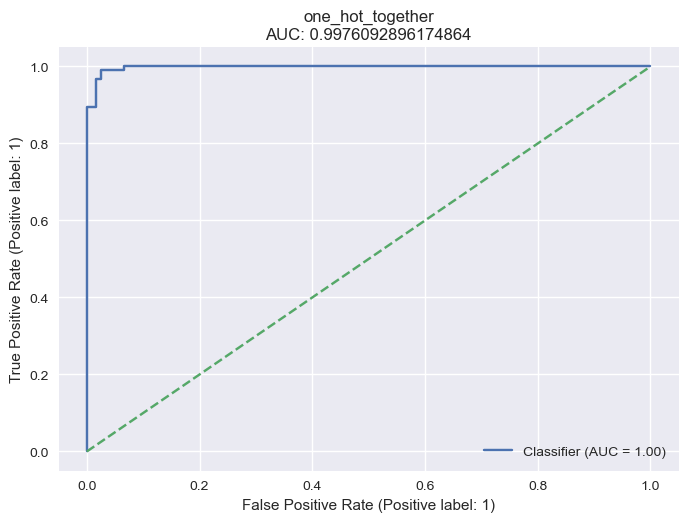

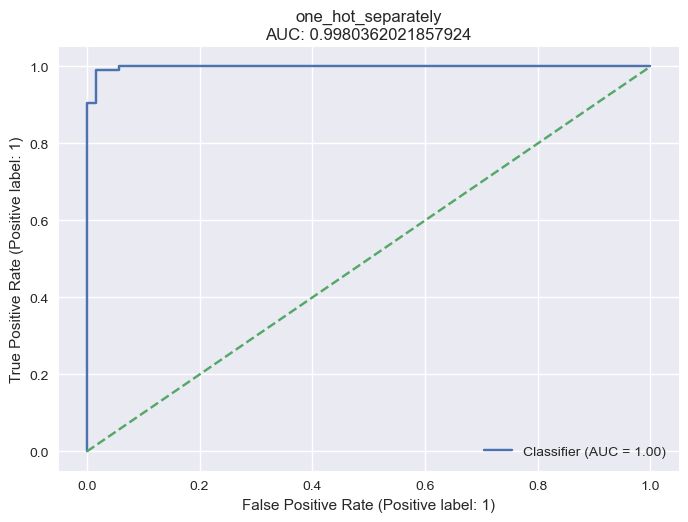

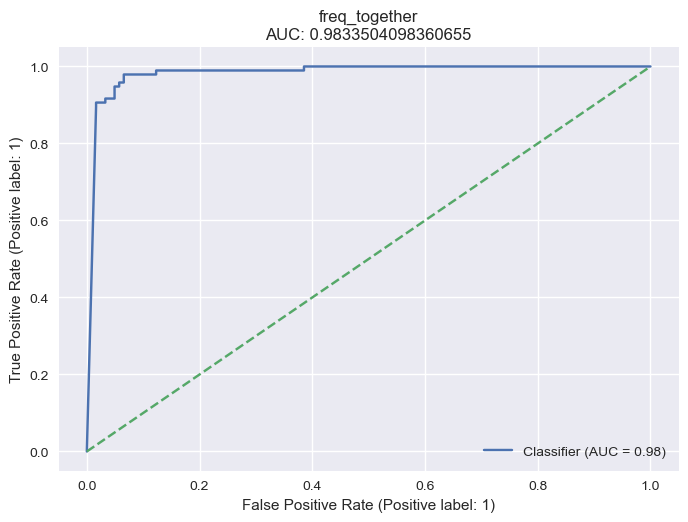

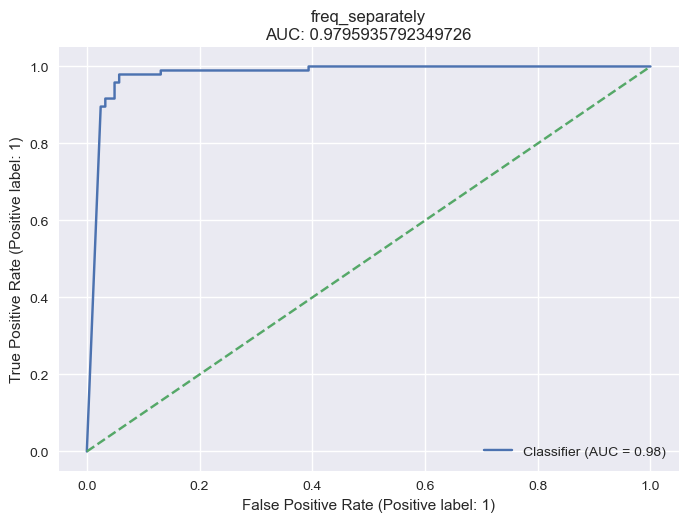

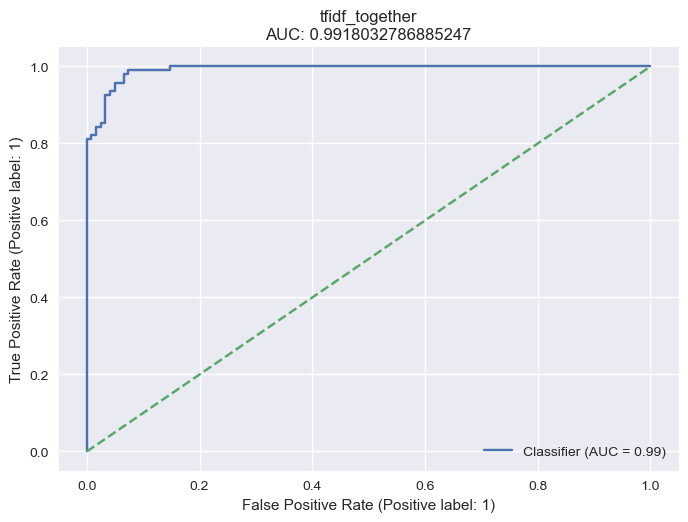

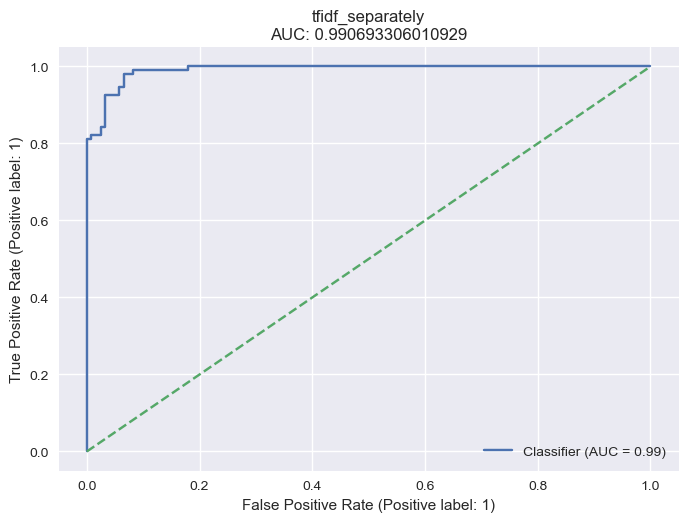

In [5]:
for func in vectorisation_funcs:
    vectorized = func(data)
    vectorized_train, msg_types_train, vectorized_test, msg_types_test = split_train_test(vectorized, msg_types, 0.2)

    clf = MultinomialNB()
    clf.fit(vectorized_train, msg_types_train)
    
    display_roc_curve(func.__name__, msg_types_test, clf.predict_proba(vectorized_test))

6. Изменим априорное распределение таким образом, чтобы число *false-positive* предсказаний равнялось нулю:

In [6]:
def score(x: np.ndarray) -> int:
    spmsg_prior_prob = x.item()
    vectorized = tfidf_separately(data)
    vectorized_train, msg_types_train, vectorized_test, msg_types_test = split_train_test(vectorized, msg_types, 0.2)

    clf = MultinomialNB(class_prior=(1.0 - spmsg_prior_prob, spmsg_prior_prob))
    clf.fit(vectorized_train, msg_types_train)
    
    return false_positive_count(msg_types_test, clf.predict(vectorized_test))

In [7]:
optimizer = minimize(score, x0=[0.1], method="Powell", bounds=[(0, 1)])
print("Best spam prior probability:", optimizer.x.item())
print("FP count:", score(optimizer.x))

Best spam prior probability: 0.14595123487077688
FP count: 0


7. Построим график зависимости точности классификации от изменения априорного распределения в логарифмированном пространстве:

In [8]:
spmsg_prior_prob = 1.0 / 2.0 ** 25
X = []
Y = []

for _ in range(26):
    vectorized = tfidf_separately(data)
    vectorized_train, msg_types_train, vectorized_test, msg_types_test = split_train_test(vectorized, msg_types, 0.2)

    clf = MultinomialNB(class_prior=(1.0 - spmsg_prior_prob, spmsg_prior_prob))
    clf.fit(vectorized_train, msg_types_train)
    
    X.append(spmsg_prior_prob)
    Y.append(len(list(filter(lambda t: t[0] == t[1], zip(msg_types_test, clf.predict(vectorized_test))))) / len(msg_types_test))
    
    spmsg_prior_prob *= 2.0

/Users/esbessonngmail.com/miniconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:566: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = np.log(class_prior)


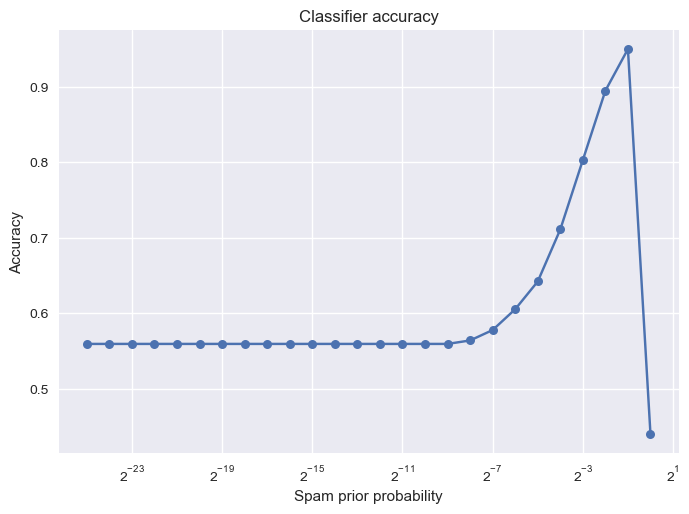

In [9]:
plt.title("Classifier accuracy")
plt.xlabel("Spam prior probability")
plt.ylabel("Accuracy")
plt.xscale(LogScale(axis=XAxis, base=2))

plt.plot(X, Y, marker="o", markersize=6.5)